In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# read in the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [29]:
len(words)

32033

In [30]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [52]:
# build the dataset

block_size = 3 # how many chars do we take to predict the next one?
X, Y = [], []
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [33]:
# 2D embedding for 27 characters 
C = torch.randn((27, 2))

In [34]:
# Create embedding
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [35]:
W1 = torch.randn((6, 100)) # Layer with 2D x 3-context input to 100 (hyper-parameter) units
b1 = torch.randn(100) # Bias on those units

In [36]:
# This creates hidden layer activations. 
# Note some pytorch efficiencies here. (1) .view very rapidly reshapes a tensor by changing the metadata. 
# (2) @ is matrix multiplication. (3) -1 means derive the size for me, pytorch!
# Other note: tanh - the hidden layer has a non-linearity.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [37]:
h.shape

torch.Size([32, 100])

In [38]:
# Output layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [39]:
# Outputs
logits = h @ W2 + b2

In [40]:
# softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [41]:
prob.shape

torch.Size([32, 27])

In [55]:
# Tidyup 
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [86]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [87]:
sum(p.nelement() for p in parameters) # total number of parameters

3481

In [88]:
# Set up autograd
for p in parameters:
    p.requires_grad = True

In [89]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [108]:
lri = []
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass   
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # pytorch function to do exponential ratio rule
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lre =.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())


#print(loss.item())


In [109]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y) 
loss

tensor(2.5131, grad_fn=<NllLossBackward0>)

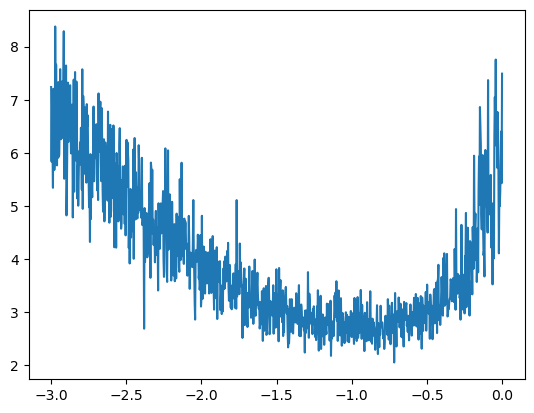

In [85]:
plt.plot(lri, lossi)

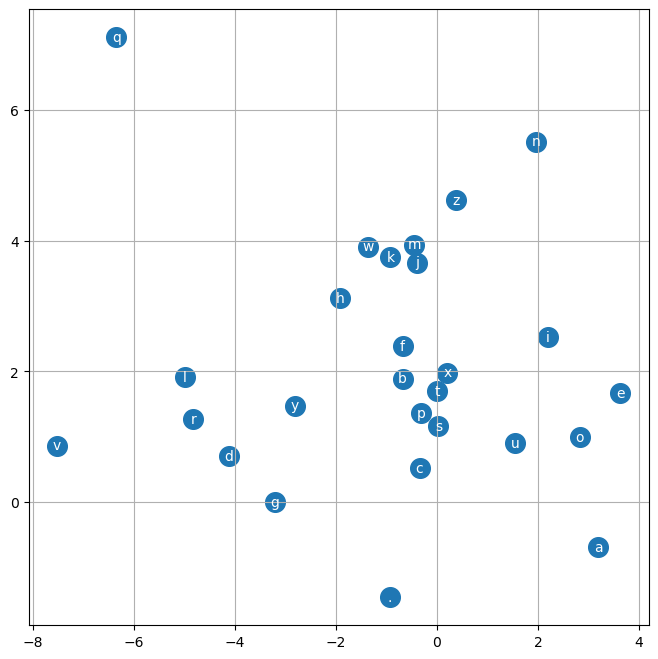

In [110]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
   emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y) # pytorch function to do exponential ratio rule
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())


In [50]:
logits.max(1)

torch.return_types.max(
values=tensor([13.4138, 17.9646, 20.6772, 20.7264, 16.8572, 13.4138, 16.1149, 14.2719,
        16.0143, 18.5009, 16.0740, 21.0530, 13.4138, 17.2576, 17.2659, 20.2015,
        13.4138, 16.7051, 15.2578, 17.2019, 18.6944, 16.1059, 10.9961, 10.7945,
        15.5882, 13.4138, 16.2896, 17.0883, 12.8242, 16.2912, 19.2261, 16.1883],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [51]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])